In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"hasanmoni","key":"9bf0c863cb37dea547dcfe75cc650d90"}'}

In [5]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission


kaggle.json


In [12]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-bin-hadoop2.7.tgz
!pip install -q findspark

In [13]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"

##### I Completed this project on Google Colaboratory. For this I written some code in upper cell to access google colaboratory. If you run this code on your local machine you don't need upper cells!

In [104]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, round, mean, isnull
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import BisectingKMeans
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D


In [17]:
spark = SparkSession.builder \
     .master("local[*]") \
     .appName("Mobile_Price_Prediction") \
     .config("spark.some.config.option", "some-value") \
     .getOrCreate()
     

## Reading Dataset

In [18]:
#Initializing File Type
file_type = 'text'
path=r'/content/drive/My Drive/Big Data Project/mobile_price.csv'
delimeter=','


In [19]:
def load_data(file_type):
    """input type of file "text" or "parquet" and Return pyspark dataframe"""
    if file_type =="text": # use text as file type input
        df = spark.read.option("header", "true") \
        .option("delimeter",delimeter)\
        .option("inferSchema", "true") \
        .csv(path) 
    else:  
        df= spark.read.parquet("example.parquet") #path file that you want import
    return df

In [20]:
df = load_data(file_type)

In [21]:
df.show(10)

+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|battery_power|blue|clock_speed|dual_sim| fc|four_g|int_memory|m_dep|mobile_wt|n_cores| pc|px_height|px_width| ram|sc_h|sc_w|talk_time|three_g|touch_screen|wifi|price_range|
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|          842|  no|        2.2|      no|  1|    no|         7|  0.6|      188|    two|  2|       20|     756|2549|   9|   7|       19|     no|          no| yes|          1|
|         1021| yes|        0.5|     yes|  0|   yes|        53|  0.7|      136|  three|  6|      905|    1988|2631|  17|   3|        7|    yes|         yes|  no|          2|
|          563| yes|        0.5|     yes|  2|   yes|        41|  0.9|      145|   five|  6|     1263|    1716|2603|  11|   2|     

In [22]:
df.printSchema()

root
 |-- battery_power: integer (nullable = true)
 |-- blue: string (nullable = true)
 |-- clock_speed: double (nullable = true)
 |-- dual_sim: string (nullable = true)
 |-- fc: integer (nullable = true)
 |-- four_g: string (nullable = true)
 |-- int_memory: integer (nullable = true)
 |-- m_dep: double (nullable = true)
 |-- mobile_wt: integer (nullable = true)
 |-- n_cores: string (nullable = true)
 |-- pc: integer (nullable = true)
 |-- px_height: integer (nullable = true)
 |-- px_width: integer (nullable = true)
 |-- ram: integer (nullable = true)
 |-- sc_h: integer (nullable = true)
 |-- sc_w: integer (nullable = true)
 |-- talk_time: integer (nullable = true)
 |-- three_g: string (nullable = true)
 |-- touch_screen: string (nullable = true)
 |-- wifi: string (nullable = true)
 |-- price_range: integer (nullable = true)



In [23]:
#total number of columns
len(df.columns)

21

In [24]:
#total number of rows
df.count()

2000

## Changing Columns Name

In [25]:
df = df.withColumnRenamed('blue', 'blue_color')
df = df.withColumnRenamed('int_memory', 'internal_memory')
df = df.withColumnRenamed('mobile_wt', 'mobile_weight')
df = df.withColumnRenamed('three_g', 'three_generation')
df = df.withColumnRenamed('wifi', 'wifi_connection')


## Categorical and Numerical Columns

In [26]:
#categorical column
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')] #just will select string data type
print("cat_cols:", cat_cols)


cat_cols: ['blue_color', 'dual_sim', 'four_g', 'n_cores', 'three_generation', 'touch_screen', 'wifi_connection']


In [27]:
#numerical columns
num_cols = [item[0] for item in df.dtypes if item[1].startswith('int') | item[1].startswith('double')] #just will select integer or double data type
print("num_cols:", num_cols)


num_cols: ['battery_power', 'clock_speed', 'fc', 'internal_memory', 'm_dep', 'mobile_weight', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'price_range']


## Summary of the Numerical Columns

In [28]:
df.select(num_cols).describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+
|summary|     battery_power|       clock_speed|               fc|   internal_memory|             m_dep|    mobile_weight|               pc|         px_height|          px_width|               ram|             sc_h|             sc_w|        talk_time|       price_range|
+-------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+
|  count|              1999|              1999|             2000|              1999|              1999|             2000|             2000|              2000|              1996|             

## Checking Missing Values 

In [29]:
#convert to pandas DataFrame
df_pd=df.toPandas()

In [30]:
#Check Missing value with proportion in Pandas DataFrame

def missing_values_table(df_pd):
    """Input pandas dataframe and Return columns with missing value&percentage and stored as pandas dataframe"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) #count percentage of null in each columns
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #join to left (as column) between mis_val and mis_val_percent and create it as dataframe
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename columns in table, mis_val to Missing Values and mis_val_percent to % of Total Values
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)         #sort column % of Total Values descending and round 1 after point(coma)
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) + 
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns
    

In [31]:
missing_values_table(df_pd)


Your selected dataframe has 21 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
n_cores,256,12.8
px_width,4,0.2
wifi_connection,3,0.2
four_g,2,0.1
battery_power,1,0.0
clock_speed,1,0.0
internal_memory,1,0.0
m_dep,1,0.0
sc_w,1,0.0


In [32]:
#Check Missing Value in Pyspark Dataframe

def count_nulls(df_final):
    """Input pyspark dataframe and return list of columns with missing value and it's total value"""
    null_counts = []          #make an empty list to hold our results
    for col in df.dtypes:     #iterate through the column data types we saw above, e.g. ('C0', 'bigint')
        cname = col[0]        #splits out the column name, e.g. 'C0'    
        ctype = col[1]        #splits out the column type, e.g. 'bigint'
        nulls = df.where( df[cname].isNull() ).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts


In [33]:
null_counts = count_nulls(df)
null_counts


[('battery_power', 1),
 ('clock_speed', 1),
 ('four_g', 2),
 ('internal_memory', 1),
 ('m_dep', 1),
 ('n_cores', 256),
 ('px_width', 4),
 ('sc_w', 1),
 ('wifi_connection', 3)]

In [34]:
#list of missing columns
list_cols_miss=[x[0] for x in null_counts]
list_cols_miss


['battery_power',
 'clock_speed',
 'four_g',
 'internal_memory',
 'm_dep',
 'n_cores',
 'px_width',
 'sc_w',
 'wifi_connection']

In [35]:
#Create dataframe which just has list_cols_miss
df_miss= df.select(*list_cols_miss)


In [36]:
df_miss.dtypes


[('battery_power', 'int'),
 ('clock_speed', 'double'),
 ('four_g', 'string'),
 ('internal_memory', 'int'),
 ('m_dep', 'double'),
 ('n_cores', 'string'),
 ('px_width', 'int'),
 ('sc_w', 'int'),
 ('wifi_connection', 'string')]

## Categorical and Numerical Columns which have missing values

In [37]:
#Define categorical columns and numerical columns which have missing value.
### for categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("catcolums_miss:", catcolums_miss)

### for numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
print("numcolumns_miss:", numcolumns_miss)


catcolums_miss: ['four_g', 'n_cores', 'wifi_connection']
numcolumns_miss: ['battery_power', 'clock_speed', 'internal_memory', 'm_dep', 'px_width', 'sc_w']


## Without Missing Values Rows

In [38]:
#Drop missing value
df_Nomiss=df.na.drop()
df_Nomiss.show(10)


+-------------+----------+-----------+--------+---+------+---------------+-----+-------------+-------+---+---------+--------+----+----+----+---------+----------------+------------+---------------+-----------+
|battery_power|blue_color|clock_speed|dual_sim| fc|four_g|internal_memory|m_dep|mobile_weight|n_cores| pc|px_height|px_width| ram|sc_h|sc_w|talk_time|three_generation|touch_screen|wifi_connection|price_range|
+-------------+----------+-----------+--------+---+------+---------------+-----+-------------+-------+---+---------+--------+----+----+----+---------+----------------+------------+---------------+-----------+
|          842|        no|        2.2|      no|  1|    no|              7|  0.6|          188|    two|  2|       20|     756|2549|   9|   7|       19|              no|          no|            yes|          1|
|         1021|       yes|        0.5|     yes|  0|   yes|             53|  0.7|          136|  three|  6|      905|    1988|2631|  17|   3|        7|             y

In [39]:
#total number of rows without missing
df_Nomiss.count()


1732

## Filling missing values

In [40]:
#fill missing value in categorical variable with most frequent
for x in catcolums_miss:
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] #group by based on categories and count each categories and sort descending then take the first value in column
    print(x, mode) #print name of columns and it's most categories 
    df = df.na.fill({x:mode}) #fill missing value in each columns with most frequent
    

four_g yes
n_cores four
wifi_connection yes


In [41]:
#fill missing value in numerical variable with average
for i in numcolumns_miss:
    meanvalue = df.select(round(mean(i))).collect()[0][0] #calculate average in each numerical column
    print(i, meanvalue) #print name of columns and it's average value
    df=df.na.fill({i:meanvalue}) #fill missing value in each columns with it's average value
    

battery_power 1239.0
clock_speed 2.0
internal_memory 32.0
m_dep 1.0
px_width 1251.0
sc_w 6.0


## Again Checking Missing data

In [42]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).toPandas()


,battery_power,blue_color,clock_speed,dual_sim,fc,four_g,internal_memory,m_dep,mobile_weight,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_generation,touch_screen,wifi_connection,price_range
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis

In [43]:
# convert spark dataframe to pandas for visualization
df_pd2=df.toPandas()


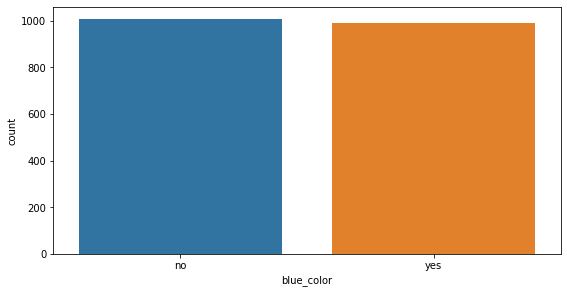

In [44]:
#Barchart for categorical variable
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(x='blue_color', data=df_pd2, order=df_pd['blue_color'].value_counts().index)
plt.show()


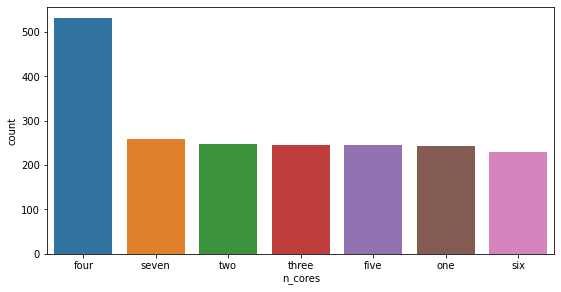

In [45]:
#Barchart for categorical variable
plt.figure(figsize=(20,10))
plt.subplot(222)
sns.countplot(x='n_cores', data=df_pd2, order=df_pd['n_cores'].value_counts().index)
plt.show()


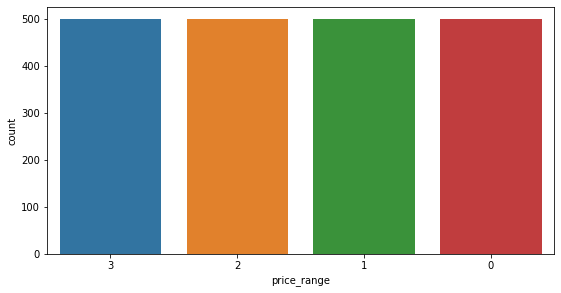

In [46]:
#Barchart for categorical variable
plt.figure(figsize=(20,10))
plt.subplot(223)
sns.countplot(x='price_range', data=df_pd2, order=df_pd['price_range'].value_counts().index)
plt.show()


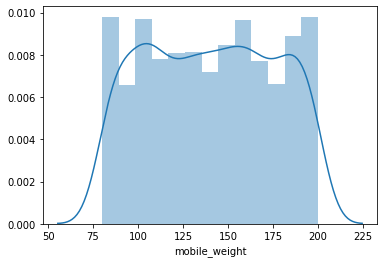

In [47]:
sns.distplot(df_pd2['mobile_weight'])
plt.show()

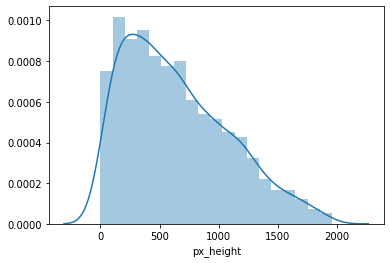

In [48]:
sns.distplot(df_pd2['px_height'])
plt.show()


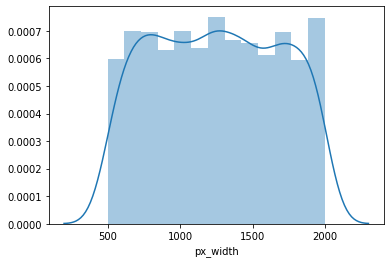

In [49]:
sns.distplot(df_pd2['px_width'])
plt.show()

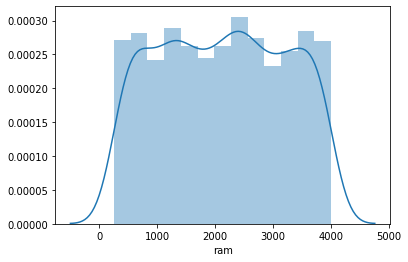

In [50]:
sns.distplot(df_pd2['ram'])
plt.show()

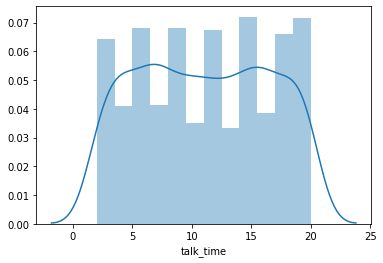

In [51]:
sns.distplot(df_pd2['talk_time'])
plt.show()

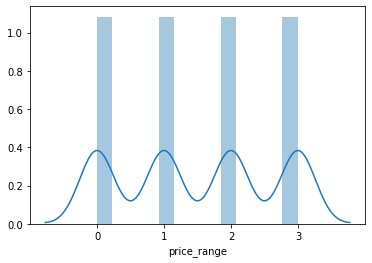

In [52]:
sns.distplot(df_pd2['price_range'])
plt.show()

## Checking Outlier

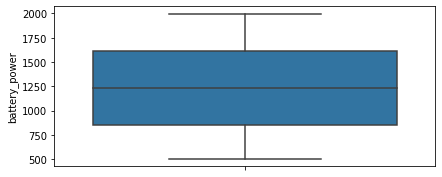

In [53]:
#Check outlier in 'battery_power'
plt.figure(figsize=(15,10))
plt.subplot(321)
sns.boxplot(y="battery_power", data=df_pd2)
plt.show()


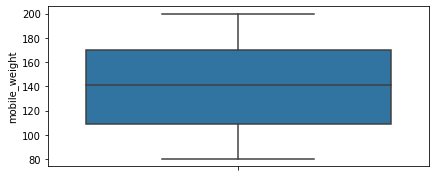

In [54]:
#Check outlier in 'mobile_weight'
plt.figure(figsize=(15,10))
plt.subplot(322)
sns.boxplot(y="mobile_weight", data=df_pd2)
plt.show()

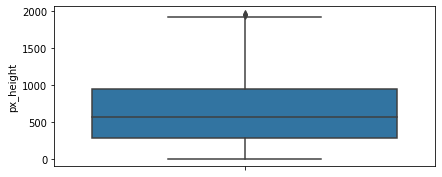

In [55]:
#Check outlier in 'px_height'
plt.figure(figsize=(15,10))
plt.subplot(323)
sns.boxplot(y="px_height", data=df_pd2)
plt.show()

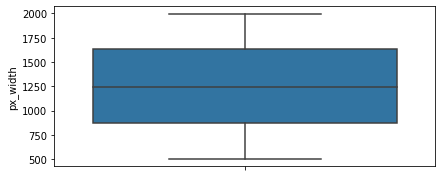

In [56]:
#Check outlier in 'px_width'
plt.figure(figsize=(15,10))
plt.subplot(324)
sns.boxplot(y="px_width", data=df_pd2)
plt.show()

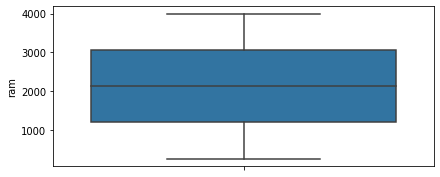

In [57]:
#Check outlier in 'ram'
plt.figure(figsize=(15,10))
plt.subplot(325)
sns.boxplot(y="ram", data=df_pd2)
plt.show()

## Handling Outlier

In [58]:
#create quantile dataframe
def quantile(e):
    """Input is dataframe and return new dataframe with value of quantile from numerical columns"""
    percentiles = [0.25, 0.5, 0.75]
    quant=spark.createDataFrame(zip(percentiles, *e.approxQuantile(num_cols, percentiles, 0.0)), ['percentile']+num_cols)

    return quant
    

In [59]:
quantile=quantile(df)
quantile.show()

+----------+-------------+-----------+---+---------------+-----+-------------+----+---------+--------+------+----+----+---------+-----------+
|percentile|battery_power|clock_speed| fc|internal_memory|m_dep|mobile_weight|  pc|px_height|px_width|   ram|sc_h|sc_w|talk_time|price_range|
+----------+-------------+-----------+---+---------------+-----+-------------+----+---------+--------+------+----+----+---------+-----------+
|      0.25|        852.0|        0.7|1.0|           16.0|  0.2|        109.0| 5.0|    282.0|   874.0|1206.0| 9.0| 2.0|      6.0|        0.0|
|       0.5|       1227.0|        1.5|3.0|           32.0|  0.5|        141.0|10.0|    564.0|  1247.0|2146.0|12.0| 5.0|     11.0|        1.0|
|      0.75|       1615.0|        2.2|7.0|           48.0|  0.8|        170.0|15.0|    947.0|  1632.0|3064.0|16.0| 9.0|     16.0|        2.0|
+----------+-------------+-----------+---+---------------+-----+-------------+----+---------+--------+------+----+----+---------+-----------+



In [60]:
def upper_value(b,c):
    """Input is quantile dataframe and name of numerical column and Retrun upper value from the column"""
    q1 = b.select(c).collect()[0][0] #select value of q1 from the column
    q2 = b.select(c).collect()[1][0] #select value of q2 from the column
    q3 = b.select(c).collect()[2][0] #select value of q3 from the column
    IQR=q3-q1  #calculate the value of IQR
    upper= q3 + (IQR*1.5)   #calculate the value of upper side
    return upper

def lower_value(b,c):
    """Input is quantile dataframe and name of numerical column and Retrun lower value from the column"""
    q1 = b.select(c).collect()[0][0] #select value of q1 from the column
    q2 = b.select(c).collect()[1][0] #select value of q2 from the column
    q3 = b.select(c).collect()[2][0] #select value of q3 from the column
    IQR=q3-q1                   #calculate the value of IQR
    lower= q1 - (IQR*1.5)       #calculate the value of lower side
    return lower
    


In [61]:
#Replacing outlier¶
def replce_outlier_up2(d,col, value):
    """Input is name of numerical column and it's upper side value"""
    d=d.withColumn(col, F.when(d[col] > value , value).otherwise(d[col]))
    return d

def replce_outlier_low2(d,col, value):
    """Input is name of numerical column and it's lower side value"""
    d=d.withColumn(col, F.when(d[col] < value , value).otherwise(d[col]))
    return d

#call function to calculate lower side and replace value under lower side with value lower side
for i in num_cols:
    lower=lower_value(quantile,i)
    df=replce_outlier_low2(df, i, lower)

#call function to calculate upper side and replace value above upper side with value upper side
for x in num_cols:
    upper=upper_value(quantile,x)
    df=replce_outlier_up2(df, x, upper)

    

In [62]:
type(df)

pyspark.sql.dataframe.DataFrame

Check distribution after replacing outlier

In [63]:
df.select(num_cols).describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+
|summary|     battery_power|       clock_speed|               fc|   internal_memory|             m_dep|    mobile_weight|               pc|        px_height|          px_width|               ram|             sc_h|              sc_w|        talk_time|       price_range|
+-------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+
|  count|              2000|              2000|             2000|              2000|              2000|             2000|             2000|             2000|              2000|              

Again Checking Outlier

In [64]:
df_pd3=df.toPandas()


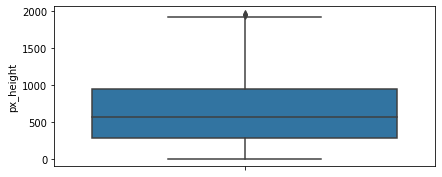

In [65]:
#Check outlier in 'px_height'
plt.figure(figsize=(15,10))
plt.subplot(326)
sns.boxplot(y="px_height", data=df_pd2)
plt.show()

## Feature Engineering

In [66]:
df.printSchema()

root
 |-- battery_power: double (nullable = true)
 |-- blue_color: string (nullable = true)
 |-- clock_speed: double (nullable = false)
 |-- dual_sim: string (nullable = true)
 |-- fc: double (nullable = true)
 |-- four_g: string (nullable = false)
 |-- internal_memory: double (nullable = true)
 |-- m_dep: double (nullable = false)
 |-- mobile_weight: double (nullable = true)
 |-- n_cores: string (nullable = false)
 |-- pc: double (nullable = true)
 |-- px_height: double (nullable = true)
 |-- px_width: double (nullable = true)
 |-- ram: double (nullable = true)
 |-- sc_h: double (nullable = true)
 |-- sc_w: double (nullable = true)
 |-- talk_time: double (nullable = true)
 |-- three_generation: string (nullable = true)
 |-- touch_screen: string (nullable = true)
 |-- wifi_connection: string (nullable = false)
 |-- price_range: double (nullable = true)



In [67]:
# define columns name for string indexer and one hot encoder processing
cat_columns_string_vec = []
for c in cat_cols:
    cat_columns_string= c+"_vec"
    cat_columns_string_vec.append(cat_columns_string)

cat_columns_string_vec


['blue_color_vec',
 'dual_sim_vec',
 'four_g_vec',
 'n_cores_vec',
 'three_generation_vec',
 'touch_screen_vec',
 'wifi_connection_vec']

In [68]:
#create index for categorical variables with stringIndexer   
stringIndexer = [StringIndexer(inputCol=x, outputCol=x+"_Index")
                  for x in cat_cols]
#use oneHotEncoder to convert categorical variable to binary
encoder = [OneHotEncoder(inputCol=x+"_Index", outputCol=y)
           for x,y in zip(cat_cols, cat_columns_string_vec)]
tmp = [[i,j] for i,j in zip(stringIndexer, encoder)]
tmp = [i for sublist in tmp for i in sublist]


In [69]:
#define columns for vector assembler processing
cols_assember=num_cols + cat_columns_string_vec
cols_assember

['battery_power',
 'clock_speed',
 'fc',
 'internal_memory',
 'm_dep',
 'mobile_weight',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time',
 'price_range',
 'blue_color_vec',
 'dual_sim_vec',
 'four_g_vec',
 'n_cores_vec',
 'three_generation_vec',
 'touch_screen_vec',
 'wifi_connection_vec']

In [70]:
#create vector assembler from cols_assember
assembler=VectorAssembler(inputCols=cols_assember, outputCol='features')
tmp += [assembler]


In [71]:
#create pipeline for stringIndexer, oneHotEncoder and vectorassembler
pipeline=Pipeline(stages=tmp)

#fit and transform pipeline to dataframe
df_final = pipeline.fit(df).transform(df)


In [72]:
df_final.show(4)


+-------------+----------+-----------+--------+---+------+---------------+-----+-------------+-------+---+---------+--------+------+----+----+---------+----------------+------------+---------------+-----------+----------------+--------------+--------------+-------------+------------+-------------+-------------+-------------+----------------------+--------------------+------------------+----------------+---------------------+-------------------+--------------------+
|battery_power|blue_color|clock_speed|dual_sim| fc|four_g|internal_memory|m_dep|mobile_weight|n_cores| pc|px_height|px_width|   ram|sc_h|sc_w|talk_time|three_generation|touch_screen|wifi_connection|price_range|blue_color_Index|blue_color_vec|dual_sim_Index| dual_sim_vec|four_g_Index|   four_g_vec|n_cores_Index|  n_cores_vec|three_generation_Index|three_generation_vec|touch_screen_Index|touch_screen_vec|wifi_connection_Index|wifi_connection_vec|            features|
+-------------+----------+-----------+--------+---+------+--

In [73]:
type(df_final)

pyspark.sql.dataframe.DataFrame

## Standard Scaler

In [74]:
#create model scaler for normalization
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

#Compute ScalerModel by fitting the StandardScaler
scalerModel = scaler.fit(df_final)


In [75]:
# Normalize each features to have unit standard deviation.
cluster_final_data = scalerModel.transform(df_final).select('scaledFeatures')
cluster_final_data.show()


+--------------------+
|      scaledFeatures|
+--------------------+
|[1.91670382331636...|
|[2.32417411354633...|
|[1.28159649943837...|
|(26,[0,1,3,4,5,6,...|
|[4.14527038273052...|
|[4.23177245551677...|
|[4.14527038273052...|
|[4.44802763748240...|
|(26,[0,1,3,4,5,6,...|
|[1.15867250126844...|
|(26,[0,1,3,4,5,6,...|
|[3.46008291144997...|
|(26,[0,1,2,3,4,5,...|
|[1.82792538019363...|
|[4.24770704787213...|
|[2.82042284689902...|
|[1.90759834197044...|
|[1.35444035020574...|
|[2.57457485055915...|
|[1.55248456947952...|
+--------------------+
only showing top 20 rows



## Model

In [93]:
k = 4
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_final)
centers = model.clusterCenters()


In [94]:
print("Cluster Centers: ")
for center in centers:
    print(center)
    

Cluster Centers: 
[1.23053521e+03 1.55598592e+00 4.37676056e+00 3.30387324e+01
 5.05281690e-01 1.38123239e+02 1.01443662e+01 1.15462148e+03
 1.68940493e+03 3.16548239e+03 1.28380282e+01 6.05281690e+00
 1.10669014e+01 2.76408451e+00 4.96478873e-01 5.07042254e-01
 5.38732394e-01 2.67605634e-01 1.47887324e-01 1.19718310e-01
 1.19718310e-01 1.16197183e-01 1.23239437e-01 7.57042254e-01
 4.75352113e-01 5.59859155e-01]
[1.23996347e+03 1.51027397e+00 4.30365297e+00 3.30136986e+01
 5.09817352e-01 1.41952055e+02 1.00228311e+01 3.82098174e+02
 1.03394749e+03 3.40169406e+03 1.21027397e+01 5.78995434e+00
 1.10045662e+01 2.62100457e+00 4.90867580e-01 5.47945205e-01
 5.15981735e-01 2.51141553e-01 1.25570776e-01 1.32420091e-01
 1.39269406e-01 1.09589041e-01 1.32420091e-01 7.62557078e-01
 5.02283105e-01 5.11415525e-01]
[1.25408555e+03 1.53436578e+00 4.19764012e+00 3.17020649e+01
 5.02212389e-01 1.40654867e+02 9.66666667e+00 6.74412242e+02
 1.27123156e+03 8.84629794e+02 1.23451327e+01 5.67994100e+00
 1.

In [95]:
#transfrom model to dataset
test=model.transform(df_final)


In [96]:
type(test)


pyspark.sql.dataframe.DataFrame

In [97]:
test.show(4)


+-------------+----------+-----------+--------+---+------+---------------+-----+-------------+-------+---+---------+--------+------+----+----+---------+----------------+------------+---------------+-----------+----------------+--------------+--------------+-------------+------------+-------------+-------------+-------------+----------------------+--------------------+------------------+----------------+---------------------+-------------------+--------------------+----------+
|battery_power|blue_color|clock_speed|dual_sim| fc|four_g|internal_memory|m_dep|mobile_weight|n_cores| pc|px_height|px_width|   ram|sc_h|sc_w|talk_time|three_generation|touch_screen|wifi_connection|price_range|blue_color_Index|blue_color_vec|dual_sim_Index| dual_sim_vec|four_g_Index|   four_g_vec|n_cores_Index|  n_cores_vec|three_generation_Index|three_generation_vec|touch_screen_Index|touch_screen_vec|wifi_connection_Index|wifi_connection_vec|            features|prediction|
+-------------+----------+-----------+

In [98]:
num_cols

['battery_power',
 'clock_speed',
 'fc',
 'internal_memory',
 'm_dep',
 'mobile_weight',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time',
 'price_range']

In [99]:
#Assign cluster to the event in data
prediction= model.transform(df_final).select(*num_cols,*cat_cols, 'prediction').collect()

#create dataframe 
prediction=spark.createDataFrame(prediction)

In [100]:
prediction.show()

+-------------+-----------+----+---------------+-----+-------------+----+---------+--------+------+----+----+---------+-----------+----------+--------+------+-------+----------------+------------+---------------+----------+
|battery_power|clock_speed|  fc|internal_memory|m_dep|mobile_weight|  pc|px_height|px_width|   ram|sc_h|sc_w|talk_time|price_range|blue_color|dual_sim|four_g|n_cores|three_generation|touch_screen|wifi_connection|prediction|
+-------------+-----------+----+---------------+-----+-------------+----+---------+--------+------+----+----+---------+-----------+----------+--------+------+-------+----------------+------------+---------------+----------+
|        842.0|        2.2| 1.0|            7.0|  0.6|        188.0| 2.0|     20.0|   756.0|2549.0| 9.0| 7.0|     19.0|        1.0|        no|      no|    no|    two|              no|          no|            yes|         3|
|       1021.0|        0.5| 0.0|           53.0|  0.7|        136.0| 6.0|    905.0|  1988.0|2631.0|17.0|

In [101]:
#grouping by our prediction of cluster
prediction.groupBy('prediction').count().sort(col('prediction')).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  284|
|         1|  437|
|         2|  678|
|         3|  601|
+----------+-----+



## Visualize the result

In [103]:
#convert prediction to Pandas
pred_pd=prediction.toPandas()

#show pandas dataframe
pred_pd.head(5)


,battery_power,clock_speed,fc,internal_memory,m_dep,mobile_weight,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,price_range,blue_color,dual_sim,four_g,n_cores,three_generation,touch_screen,wifi_connection,prediction
0,842.0,2.2,1.0,7.0,0.6,188.0,2.0,20.0,756.0,2549.0,9.0,7.0,19.0,1.0,no,no,no,two,no,no,yes,3
1,1021.0,0.5,0.0,53.0,0.7,136.0,6.0,905.0,1988.0,2631.0,17.0,3.0,7.0,2.0,yes,yes,yes,three,yes,yes,no,0
2,563.0,0.5,2.0,41.0,0.9,145.0,6.0,1263.0,1716.0,2603.0,11.0,2.0,9.0,2.0,yes,yes,yes,five,yes,yes,no,0
3,615.0,2.5,0.0,10.0,0.8,131.0,9.0,1216.0,1786.0,2769.0,16.0,8.0,11.0,2.0,yes,no,no,six,yes,no,no,0
4,1821.0,1.2,13.0,44.0,0.6,141.0,14.0,1208.0,1212.0,1411.0,8.0,2.0,15.0,1.0,yes,no,yes,two,yes,yes,no,2


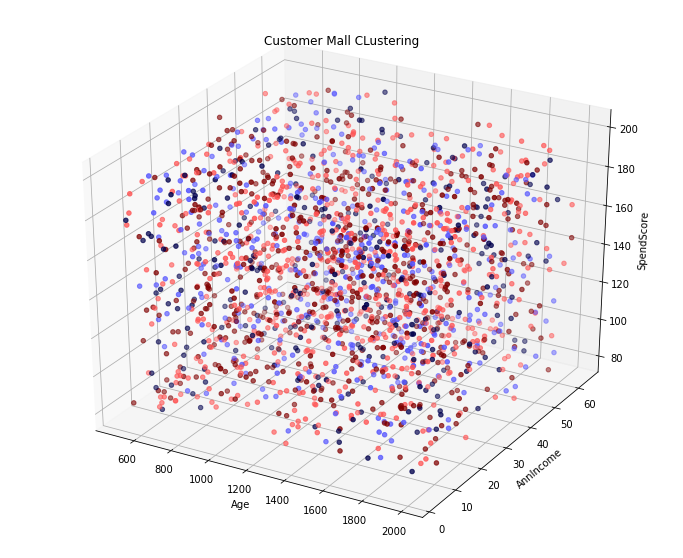

In [106]:
#Create 3d visualization
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pred_pd.battery_power, pred_pd.internal_memory, pred_pd.mobile_weight, c=pred_pd.prediction, cmap="seismic")
threedee.set_title('Customer Mall CLustering')
threedee.set_xlabel('Age')
threedee.set_ylabel('AnnIncome')
threedee.set_zlabel('SpendScore')
plt.show()
